# Techlent Price Prediction Challenge

### Objective

We are an agency helping our customers purchase XoX (a made-up product) from various makers. Price is one of the most important things we care about. We need to estimate the price of a XoX before we recommend it to our customers. However, the estimations vary significantly with our employees' experience. 

We would like you to build a machine learning model to accurately predict the price for a future purchase and provide insights to help us explain the predicted price to our customers. Please note that neither our customers nor us have any knowledge about machine learning. A sample of our sales record is available in ../data/sales.csv.

***Requirement***
1. Preprocess, clean, analyze and visualized the provided data. A few sentences or plots describing your approach will suffice. Any thing you would like us to know about the price?
2. Build a machine learning model to help us determine the price for a purchase. Discuss why you choose the approaches, what alternatives you consider, and any concerns you have. How is the performance of your model?
3. Help us understand how the price is predicted (again, a few sentences will suffice).

#### Load Data and Overview

#### Load python pandas modules

In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.datasets import make_classification
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
#load data
df = pd.read_csv('sales.csv')
df.dropna(subset=['price'], inplace=True)

In [3]:
# Recommendation for future work
# 'Backward elimination', calculate P value feature dropout
# time randomsplit v
# Feature selection
# cost fill interpolation

#### 1. Any thing you would like us to know about the price? 
Preprocess, clean, analyze and visualized the provided data. A few sentences or plots describing your approach will suffice. 

In [4]:
df.head(2)

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm


#### Data need cleaning for regression analysis

In [5]:
df.describe()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
count,2211,3186,3183,3186,3186,3186,2365,2932,3186,3183,3183
unique,185,3157,119,1277,64,5,879,2824,161,41,13
top,$66k,"$92,392",2 Ton 950 Kg,Oct 05 2001,D,advanced,M14196,IN732638,2.54 meters,99 cm,26 cm
freq,104,2,126,8,485,1320,17,8,63,268,899


***Note:*** 
Data are all strings cannot be easily analysed. Feature engineering and cleaning need to be done prior to detailed data analysis

#### check missing value: there are some missing values


In [42]:
df.isnull().sum()

cost             975
price              0
weight             3
purchase_date      0
product_type       0
product_level      0
maker            821
ingredient       254
height             0
width              3
depth              3
dtype: int64

#### check duplicates

In [43]:
# check duplicate records: No duplicates
df.duplicated().any()

False

# Let's split data by time and convert year in to datetime

#### Split train_raw into X_train, y_train, X_test, y_test

In [20]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year

train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

In [21]:

features = list(df.columns)
target = 'price'
features.remove(target)

def price2num(x):
    if type(x) == str: 
        x = x.strip('$').replace(',', '')
    return float(x)

X_train = train_raw[features]
y_train = train_raw[target].map(price2num)

X_test = test_raw[features]
y_test = test_raw[target].map(price2num)

#### check datatype: variables are most objects
#### data transformation
1. they need to be convert to floats for regression
2. year needs to be convert to timeseries features
3. the target is the price


In [22]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3186 entries, 0 to 3196
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cost           2211 non-null   object
 1   price          3186 non-null   object
 2   weight         3183 non-null   object
 3   purchase_date  3186 non-null   object
 4   product_type   3186 non-null   object
 5   product_level  3186 non-null   object
 6   maker          2365 non-null   object
 7   ingredient     2932 non-null   object
 8   height         3186 non-null   object
 9   width          3183 non-null   object
 10  depth          3183 non-null   object
 11  year           3186 non-null   int64 
dtypes: int64(1), object(11)
memory usage: 323.6+ KB


#### Preprocess, clean, analyze and visualized the provided data. A few sentences or plots describing your approach will suffice. 

#### Let's group data by types

In [23]:
# df.columns
num_v=['cost','weight','height','width','depth']
cat_v=['product_level','product_type','maker', 'ingredient']
time_v=['purchase_date']

# Numerical Feature Clean up

#### we have built a class to leaning numerical data, let's implement it to clean up the data

In [24]:
class num_Transformer(object):
    
    def fit(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        df['weight'] = X.weight.map(self.weight2num)
        df['height'] = X.height.map(self.height2num)
        df['width'] = X.width.map(self.width2num)
        df['depth'] = X.depth.map(self.depth2num)
        # df['cost'] =df.interpolate()
        self.mean = df.mean()
        
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        df['weight'] = X.weight.map(self.weight2num)
        df['height'] = X.height.map(self.height2num)
        df['width'] = X.width.map(self.width2num)
        df['depth'] = X.depth.map(self.depth2num)
        return df.fillna(self.mean)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def cost2num(self, x):
        if type(x) == str: 
            x = x.strip('$').strip('k')
            return float(x)*1000
        else:
            return x
    
    def height2num(self, x):
        if type(x) == str: 
            x = x.strip(' meters')
            return float(x)
        else:
            return x
    
    def width2num(self, x):
        if type(x) == str: 
            x = x.strip(' cm')
            return float(x)
        else:
            return x
        
    def depth2num(self, x):
        if type(x) == str: 
            x = x.strip(' cm')
            return float(x)
        else:
            return x
        
    def weight2num(self, x):
        if type(x) == str:
            x = x.strip("Kg").replace(" ", "").split("Ton")
            return float(x[0])*1000 + float(x[1])
        else:
            return x

In [25]:
numtfm=num_Transformer()
num_table=numtfm.fit_transform(X_train, y_train)
nm_col=num_table.columns

#### we remove data and convert variables into numerical forms

#### Categorical Feature Clean up

In [26]:
class ProdLevel_Transformer(object):
    
    def fit(self, X, y=None):
        if 'product_level' in X.columns:
            self.keys = set(X.product_level)

    
    def transform(self, X, y=None):
        if 'product_level' in X.columns:
            res = {}
            for key in self.keys:
                res[key] = [0]*len(X.product_level)    
            for i, item in enumerate(X.product_level):
                if item in self.keys:
                    res[item][i] = 1
            df=pd.DataFrame(res)
            self.X_copy=df
            return self.X_copy
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y) 
    
    def get_feature_names(self, X, y=None):
        self.colnames=self.X_copy.columns
        return self.colnames

<AxesSubplot:>

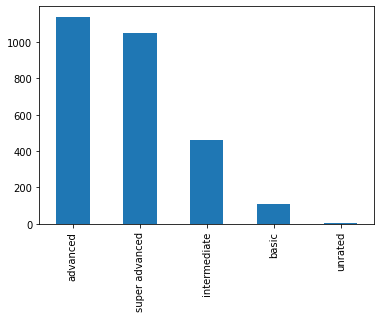

In [27]:
train_raw.product_level.value_counts().plot(kind='bar')

#### One Hot Encoding

In [28]:
train_raw.shape, X_train.shape, y_train.shape

((2757, 12), (2757, 11), (2757,))

In [29]:
ptf = ProdLevel_Transformer()
prodlevel=ptf.fit_transform(train_raw, y_train)
prodlevel=ptf.fit_transform(X_train, y_train)
pl_col=prodlevel.columns

#### build a class for Product type transformer

In [30]:
class producttype_Transformer(object):
    '''
    inputs are X DataFrame
    output create dummy features for X.product_type
    
    '''
    def fit(self, X, y=None):
        pass
    
    def transform(self, X, y=None):
        #create dummy file 
        if 'product_type' in X.columns:
            X.pt1=X.product_type.apply(lambda x:str(x).split(',')[0])
            pt1_dummy=pd.get_dummies(X.pt1)
            X.pt2=X.product_type.apply(self.prodT)
            pt2_dummy=pd.get_dummies(X.pt2)

            #combine pt1_dummy, pt2_dummy into one
            features=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W']
            pt_combine=pd.DataFrame()
            for feature in features:
            #     print(feature)
                if feature in pt1_dummy.columns and feature in pt2_dummy.columns:
                    pt_combine[feature]=pt1_dummy[feature] +pt2_dummy[feature]
                elif feature in pt1_dummy.columns and feature not in pt2_dummy.columns:
                    pt_combine[feature]=pt1_dummy[feature]
                elif feature not in pt1_dummy.columns and feature in pt2_dummy.columns:
                    pt_combine[feature]=pt2_dummy[feature]
                else:
                    pt_combine[feature]=0

        self.X=pt_combine
        return self.X

    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    
    #extract the second product type
    def prodT(self, x):
    #split cell by ',' 
        _str=str(x).split(',')

        nlen=len(_str)
    #     print(_str, nlen)
        if nlen<=1:
            return 'ZZZ'
        else:
            return _str[1]


In [31]:
#product type encoding
producttype_Transformer=producttype_Transformer()
producttype_Transformer.fit_transform(train_raw).head(3)

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


#### could later test cordinal encoder and one hot encoder for feature engineering

In [32]:
num_v=['cost','weight','height','width','depth']
cat_v=['product_level','product_type','maker', 'ingredient']
time_v=['purchase_date']

### transfer ingridient feature using count vectorizer

In [33]:
class Ingridient_Transformer(object):
    '''
    inputs are X_train DataFrame, impute and vectorize
    output is the vectorized ingrideient of each category
    
    '''
#     from scipy.sparse import csr_matrix
    
    def fit(self, X, y=None):
        if 'ingredient' in X.columns: # impute ingridient feature
            X.loc[X['ingredient'].isna(),'ingredient']='unknown_ingredient'
            self.vectorizer = CountVectorizer()
            self.vectorizer = self.vectorizer.fit(X['ingredient'])
    
    def transform(self, X, y=None):
        if 'ingredient' in X.columns:
            X.loc[X['ingredient'].isna(),'ingredient']='unknown_ingredient'            
        return self.vectorizer.transform(X['ingredient'])

    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

#### Ingridient Encoding

In [34]:
Ingridient_Transformer=Ingridient_Transformer()
Ingridient_Transformer.fit_transform(train_raw, y_train)

<2757x1858 sparse matrix of type '<class 'numpy.int64'>'
	with 11832 stored elements in Compressed Sparse Row format>

### Clean and impute df.maker

In [35]:
df.maker.isnull().sum()/df.maker.count()

0.3471458773784355

***Note:*** we have 35% of missing data. We need to work on imputation

<AxesSubplot:>

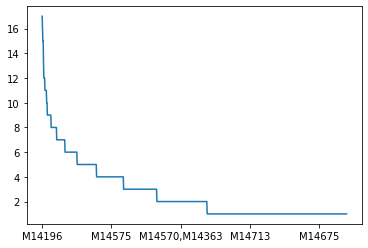

In [36]:
df.maker.value_counts().plot()

***Note:*** Data frequency distribution. There are many marks have only one sample. We coould impute using frequency imputer

In [37]:
train_raw.maker.value_counts()

M14346                                                                   15
M14196                                                                   14
M14170                                                                   13
M14163                                                                   13
M14313                                                                   12
                                                                         ..
M14986                                                                    1
M14327                                                                    1
M14744,M14501,M14257,M14745,M14202,M14746,M14747,M14595,M14686,M14206     1
M14371                                                                    1
M14992                                                                    1
Name: maker, Length: 771, dtype: int64

In [38]:
class Maker_Freq_Transformer(object):
    def __init__(self):
        self.level_dict = None
        
    def fit(self, X, y=None):
        if 'maker' in X.columns:
            X.loc[(X['maker'].isna()),'maker']='M14346' #impute missing with most popular kind 'M14346'
            self.level_dict = X.maker.value_counts()
            
    
    def transform(self, X, y=None):
        #Input: X, Series
        if 'maker' in X.columns:
            df = pd.DataFrame()
            df['maker'] = X.maker.map(self.level_dict)
            self.X=pd.DataFrame(df['maker'])
        return self.X
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)


#### Freqnuency Imputation results

In [39]:
ftf = Maker_Freq_Transformer()
yy=ftf.fit_transform(X_train)
maker_col=['maker']
yy


,maker
0,7
1,767
2,767
3,767
4,5
...,...
2752,6
2753,4
2754,3
2755,4


# Time Feature Clean up

#### Let's build a time feature transformer class and create few new features

In [40]:
time_table_index=pd.to_datetime(train_raw['purchase_date'])


In [41]:
class time_Transformer(object):
    '''
    inputs are X_train DataFrame
    output is the time features of each category
    
    '''

    def fit(self, X, y=None):
            pass

    
    def transform(self, X, y = None):
    #getting the three extra attributes by dividing appropriate attributes
        if 'purchase_date' in X.columns:
            X['purchase_date'] = pd.to_datetime(X['purchase_date'], errors='coerce')

    #4.  extracting date from timestamp    
            X["purchase_date_year"]= X['purchase_date'].dt.year
            X["purchase_date_month"]= X['purchase_date'].dt.month
            X['purchase_date_weekday'] = X['purchase_date'].dt.weekday
            X["purchase_date_day"]= X['purchase_date'].dt.day
            
    #5 drop X['purchase_date'] from X
            X.drop(['purchase_date'],axis=1, inplace=True)
            self.df=X[["purchase_date_year","purchase_date_month", 'purchase_date_weekday',"purchase_date_day"]]

            return self.df
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X) 

In [42]:
# #QC the process
# tt=time_Transformer()
# time_table=tt.transform(X_train, y_train)
# time_col=time_table.columns
# time_col

# Join Cleaned Data for EDA

#### Join Cleaned Data for EDA
including num_table, product level, time_table, price

In [43]:
train_raw.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth,year
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm,2008
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm,1997
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm,2001
3,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm,2000
4,$59k,"$60,320",2 Ton 930 Kg,Aug 19 2011,H,super advanced,M14124,"IN732067,IN732068,IN732069,IN732070,IN732071,I...",2.71 meters,96 cm,25 cm,2011


In [44]:
Combined_tbl=pd.concat((num_table, train_raw[['product_level']], time_table, time_table_index, pd.DataFrame(y_train)), axis=1)

NameError: name 'time_table' is not defined

In [45]:
Combined_tbl.head()

NameError: name 'Combined_tbl' is not defined

#### Plot histograms for QC

In [74]:
#Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns

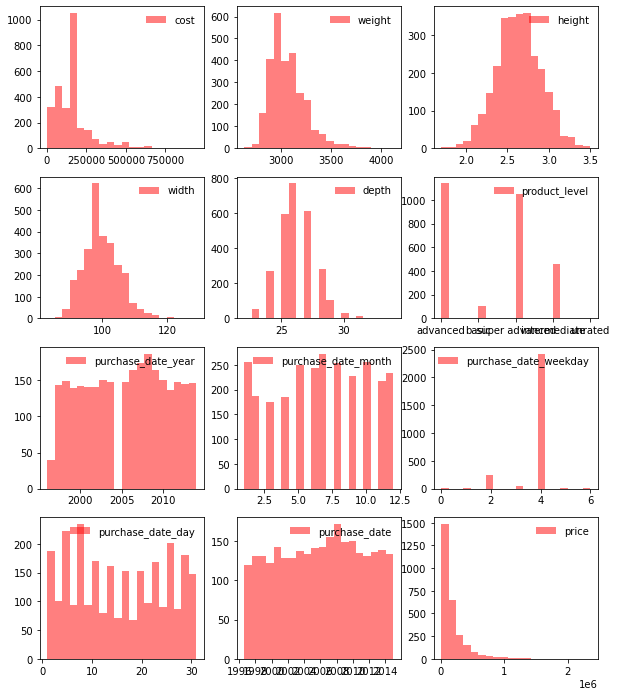

In [75]:
ncols = 3
# nrows=2
df=Combined_tbl
nrows = int(np.ceil(len(df.columns) / (1.0*ncols)))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 12))

# Lazy counter so we can remove unwated axes
counter = 0
for i in range(nrows):
    for j in range(ncols):

        ax = axes[i][j]

        # Plot when we have data
        if counter < len(df.columns):

            ax.hist(df[df.columns[counter]], bins=20, color='red', alpha=0.5, label='{}'.format(df.columns[counter]))
            leg = ax.legend(loc='upper right')
            leg.draw_frame(False)

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1

plt.show()

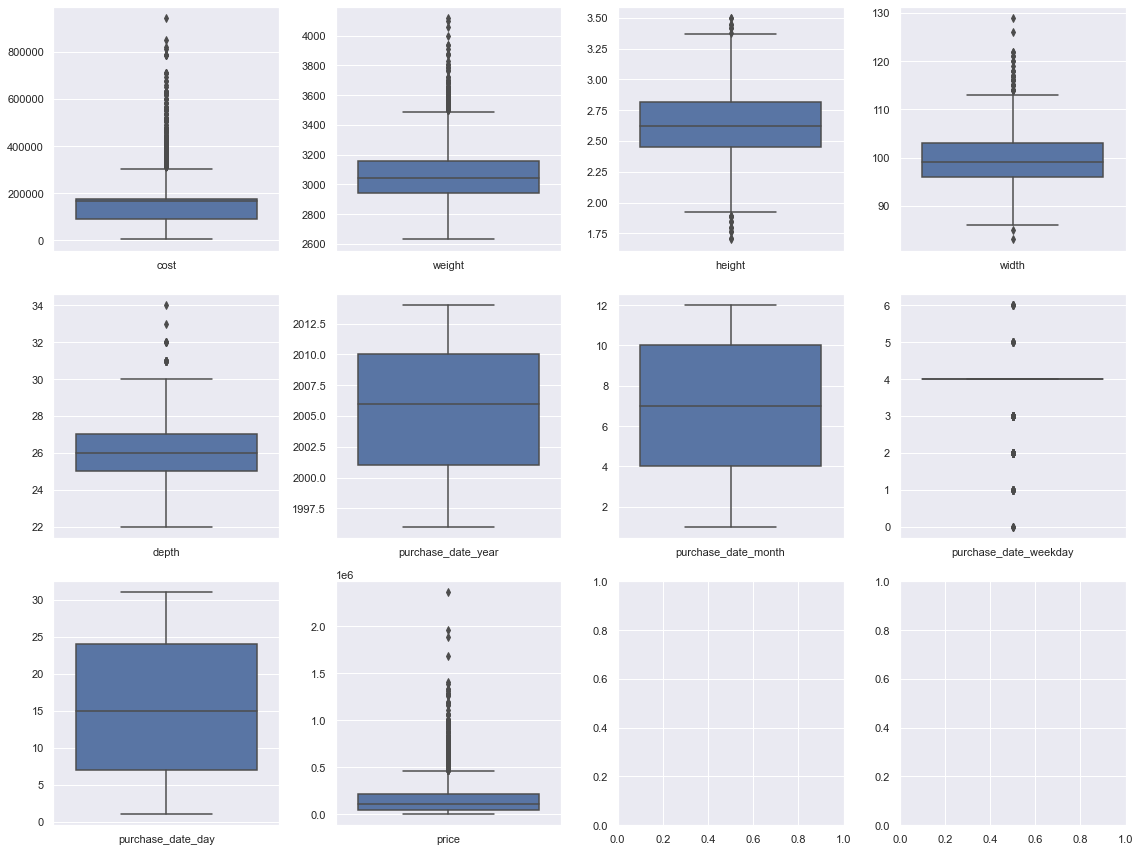

In [76]:
ncols = 4
nrows=3
sns.set(rc={'figure.figsize':(16,12)})
df1=df[['cost', 'weight', 'height', 'width', 'depth', 'purchase_date_year', 'purchase_date_month', 'purchase_date_weekday',
       'purchase_date_day','price']]
fig, axes = plt.subplots(nrows,ncols) # create figure and axes
for i,el in enumerate(list(df1.columns.values)[:]):
    sns.boxplot(data=df1[[ el]], ax=axes.flatten()[i])

plt.tight_layout() 

plt.show()

***Note***
1. many outliers due to skewed distrivution in cost, weight, width etc.
2. transaction were done mostly on Friday 

#### Multivariate Analysis

<AxesSubplot:>

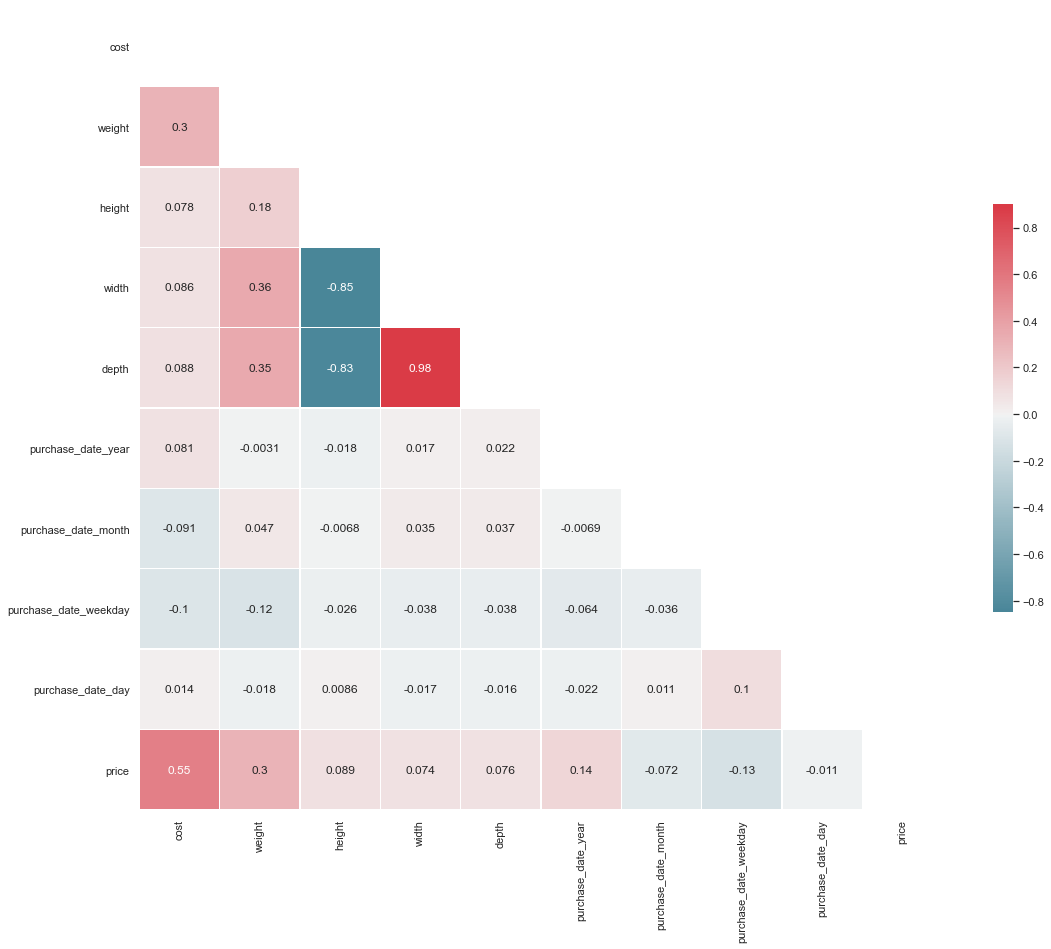

In [77]:
# printmd('**independent and dependent variables, which features have high correlation with dependent var. and how about colinearlity?**')
sns.set(style="white")
corr = df.corr()

#Generate a mask for the upper triangle:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#Set up the matplotlib figure and a diverging colormap:
f, ax = plt.subplots(figsize=(18, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#Draw the heatmap with the mask and correct aspect ratio:
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0, annot=True, 
square=True, linewidths=.5, cbar_kws={"shrink": .5})

***Note***
1. strong correlation of price and cost, weight, which indicates we can have good prediction. There are some indication of time and week day has correlation with price. we may want to look into details of the price and time relationships
2. strong colineality between cost, weight height, depth and width, we need to handle it in later model preparation

In [78]:
df.head()

,cost,weight,height,width,depth,product_level,purchase_date_year,purchase_date_month,purchase_date_weekday,purchase_date_day,purchase_date,price
0,333000.000000,3090.0,2.76,97.0,26.0,advanced,2008,12,4,19,2008-12-19,300492.0
1,166184.183143,3030.0,2.67,98.0,26.0,basic,1997,9,2,10,1997-09-10,430570.0
2,270000.000000,3040.0,3.00,93.0,24.0,basic,2001,9,2,5,2001-09-05,213070.0
3,97000.000000,2970.0,2.47,101.0,26.0,advanced,2000,1,2,12,2000-01-12,122659.0
4,59000.000000,2930.0,2.71,96.0,25.0,super advanced,2011,8,4,19,2011-08-19,60320.0


#### change product_level to ordinal value 

#### create a  FridaynoFriday Feature 

In [79]:
df['FNF']=df['purchase_date_weekday'].apply(lambda x: 1 if x==4 else 0)
df.head()

,cost,weight,height,width,depth,product_level,purchase_date_year,purchase_date_month,purchase_date_weekday,purchase_date_day,purchase_date,price,FNF
0,333000.000000,3090.0,2.76,97.0,26.0,advanced,2008,12,4,19,2008-12-19,300492.0,1
1,166184.183143,3030.0,2.67,98.0,26.0,basic,1997,9,2,10,1997-09-10,430570.0,0
2,270000.000000,3040.0,3.00,93.0,24.0,basic,2001,9,2,5,2001-09-05,213070.0,0
3,97000.000000,2970.0,2.47,101.0,26.0,advanced,2000,1,2,12,2000-01-12,122659.0,0
4,59000.000000,2930.0,2.71,96.0,25.0,super advanced,2011,8,4,19,2011-08-19,60320.0,1


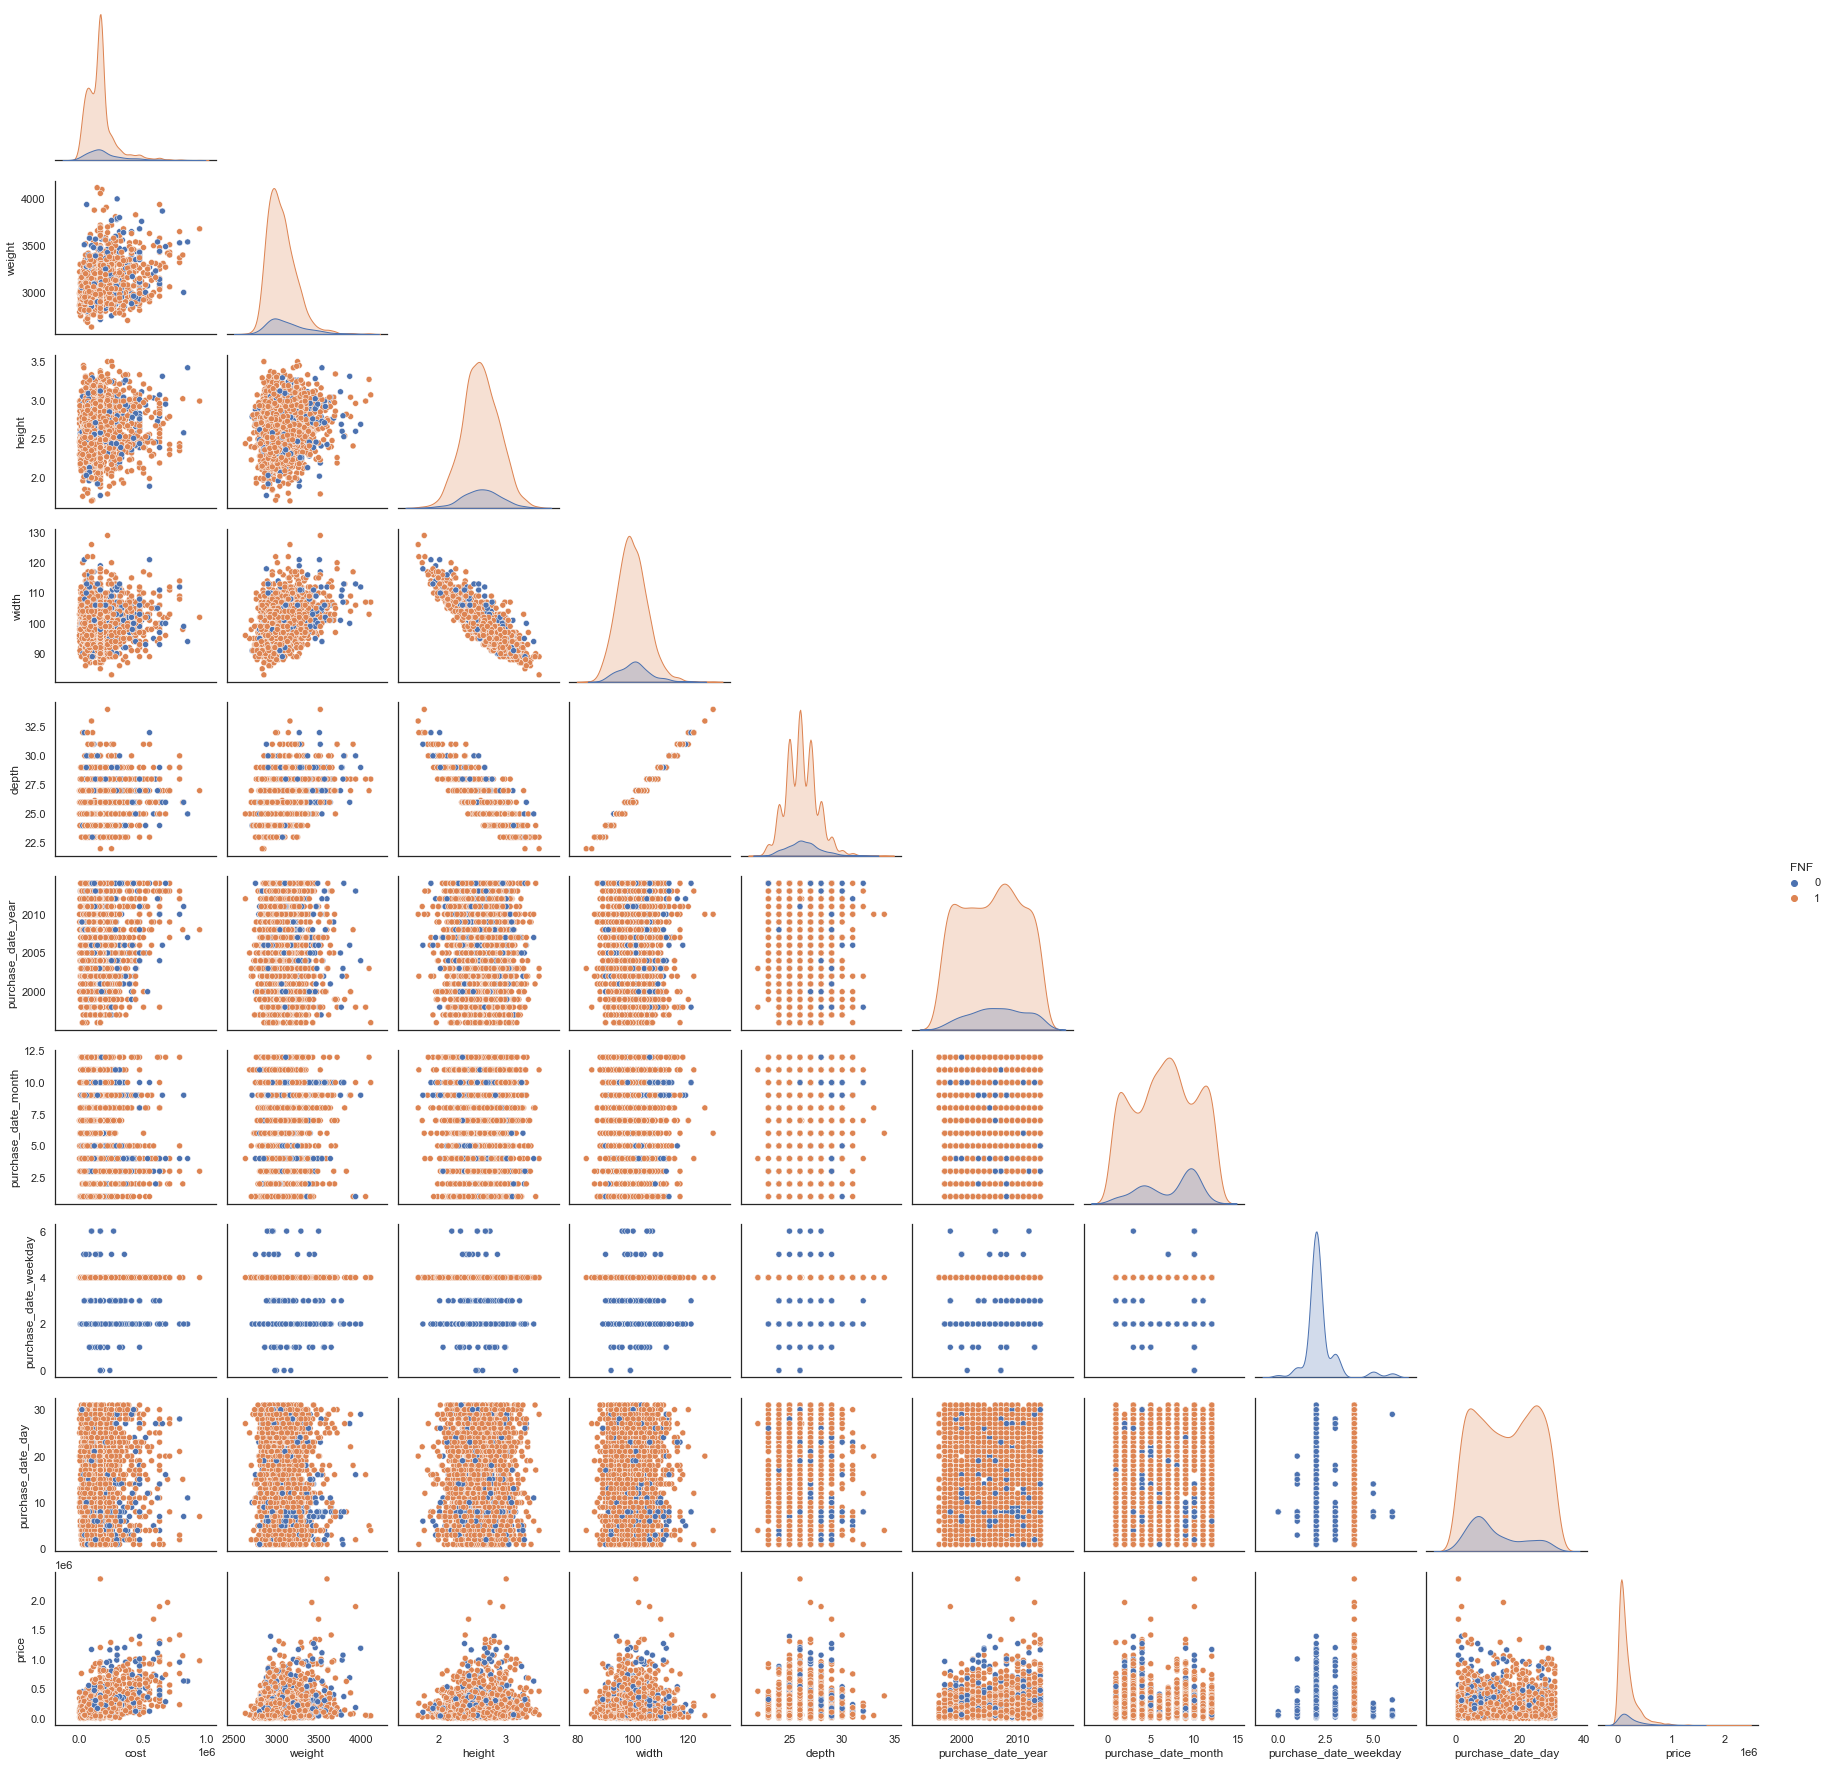

In [80]:
sns.set(style="white")
sns.pairplot(df, hue='FNF', corner=True)

***Note***
1. strong correlation of price and cost, weight, which indicates we can have good prediction. There are some indication of time and week day has correlation with price. we may want to look into details of the price and time relationships
2. strong colineality between cost, weight height, depth and width, we need to handle it in later model preparation

### Batch visualization with Datetime

#### price vs. years: 
1. gradual increase of price for all brands
2. basic type price oscillate alot

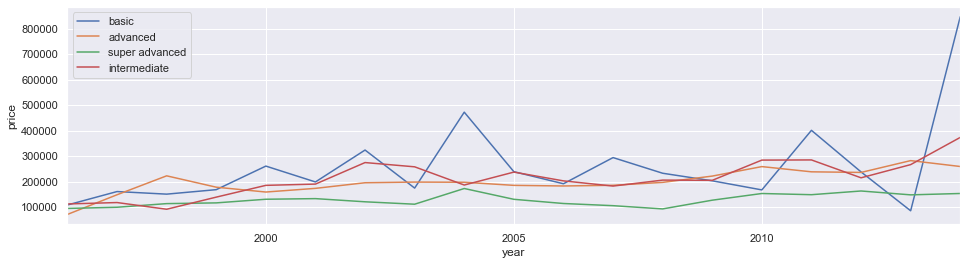

In [81]:
sns.set(rc={'figure.figsize':(16,4)})
features=['basic', 'advanced', 'super advanced','intermediate' ]
temp=Combined_tbl.set_index('purchase_date')
for feature in features:
    temp[temp['product_level']==feature].price.resample('A').mean().plot(label=feature)
plt.xlabel("year")
plt.ylabel("price")
plt.legend(loc="upper left")

#### price vs. month: 
1. two peak seasons spring and fall

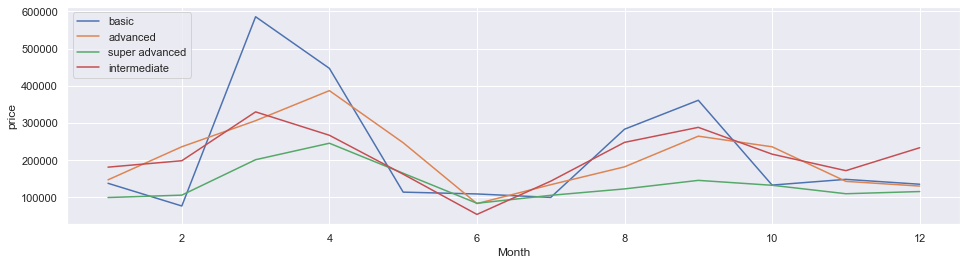

In [82]:
for feature in features:
    df[df['product_level']==feature].groupby('purchase_date_month').price.mean().plot(label=feature)
plt.xlabel("Month")
plt.ylabel("price")
plt.legend(loc="upper left")


#### price vs. weekday: 
1. two peak seasons spring and fall

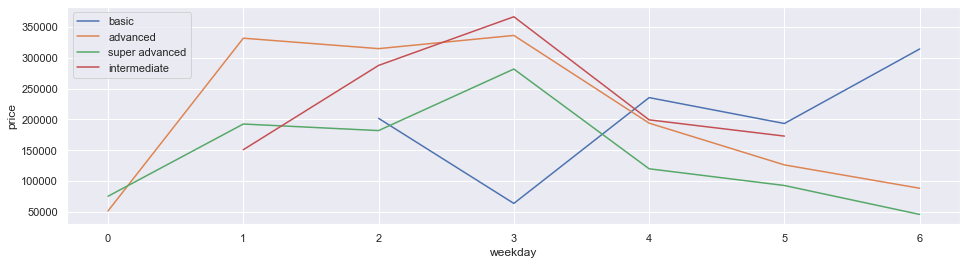

In [83]:
for feature in features:
    df[df['product_level']==feature].groupby('purchase_date_weekday').price.mean().plot(label=feature)
plt.xlabel("weekday")
plt.ylabel("price")
plt.legend(loc="upper left")


#### price vs. weekday: 
1. basic price change is more among weekends: working moms?
2. other type change is more on weekday: customer house moms?

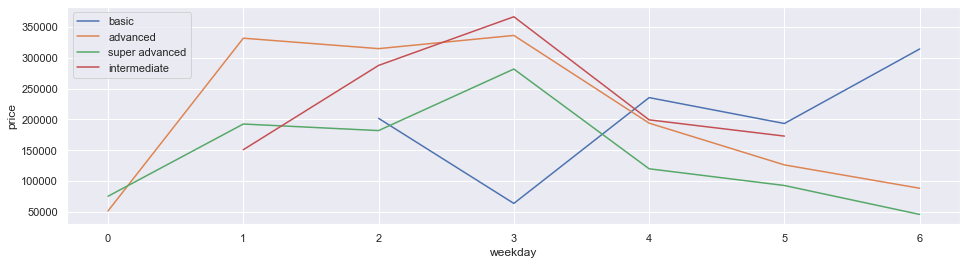

In [84]:
for feature in features:
    df[df['product_level']==feature].groupby('purchase_date_weekday').price.mean().plot(label=feature)
plt.xlabel("weekday")
plt.ylabel("price")
plt.legend(loc="upper left")






#### transaction vs. weekday: 
Friday has by far the most transaction!

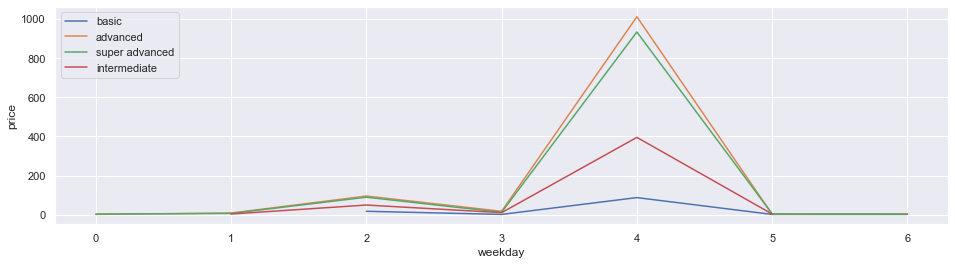

In [85]:
#     df.set_index('App').T.plot(kind='bar', stacked=True)

for feature in features:
    df[df['product_level']==feature].groupby('purchase_date_weekday').price.count().plot( label=feature)
plt.xlabel("weekday")
plt.ylabel("price")
plt.legend(loc="upper left")


#### Let's check what causes the spike of the price recently. Let's plot features
increase of price by year
recent spike of basic

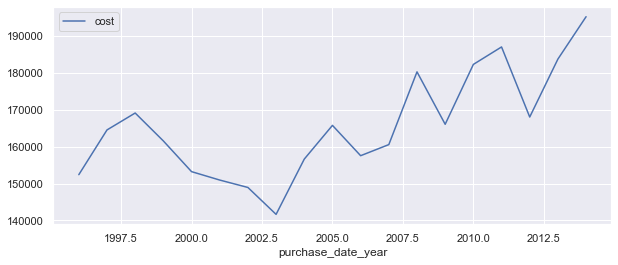

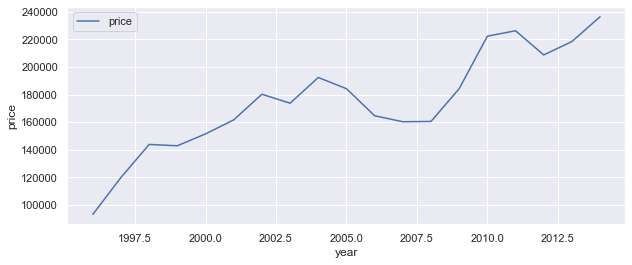

In [87]:
# otherfeatures=['cost', 'weight', 'height', 'width', 'price']
otherfeatures=['cost', 'price']
for i, feature in enumerate(otherfeatures):
    df[['purchase_date_year',feature]].groupby('purchase_date_year').mean().plot(label=feature,sharex=True, figsize=(10, 4))
plt.xlabel("year")
plt.ylabel("price")
plt.legend(loc="upper left")


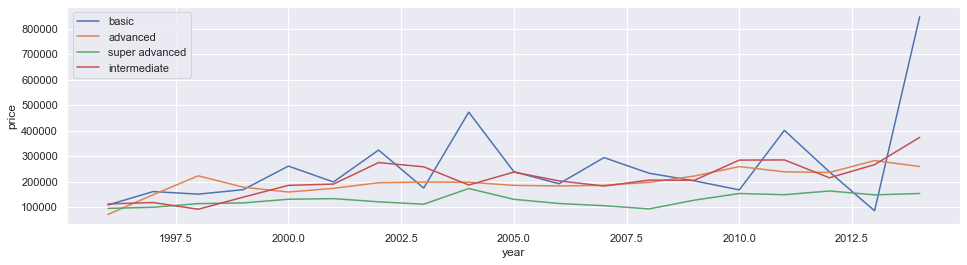

In [88]:
for feature in features:
    temp[temp['product_level']==feature].groupby('purchase_date_year').price.mean().plot(label=feature)
plt.xlabel("year")
plt.ylabel("price")
plt.legend(loc="upper left")

***Obersvations*** 
1. skewed distribution of cost and weights
2. purchase date happens predominantly on Friday
3. height and weight are normally distributed
4. Seems like some cyclic behaviour in purchase days

# EDA and Feature Engineering

#### call the split function the second time to allow pipleline function correctly after EDA

In [101]:
df = pd.read_csv('../data/sales.csv')
df.dropna(subset=['price'], inplace=True)

df['year'] = pd.to_datetime(df.purchase_date).dt.year

train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

features = list(df.columns)
target = 'price'
features.remove(target)

def price2num(x):
    if type(x) == str: 
        x = x.strip('$').replace(',', '')
    return float(x)

X_train = train_raw[features]
y_train = train_raw[target].map(price2num)

X_test = test_raw[features]
y_test = test_raw[target].map(price2num)

In [142]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """Select only specified columns."""
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

# Define product level pipeline
plf_pipe = Pipeline([
    ('selector', ColumnSelector(cat_v)),
    ('plf', ProdLevel_Transformer())
])

# Define product type pipeline
ptf_pipe = Pipeline([
    ('selector', ColumnSelector(cat_v)),
    ('ptf', producttype_Transformer)
])

# Define Ingridient pipeline
itf_pipe = Pipeline([
    ('selector', ColumnSelector(cat_v)),
    ('itf', Ingridient_Transformer)
])

# Define maker pipeline
maker_pipe = Pipeline([
       ('selector', ColumnSelector(cat_v)),
       ('maker', Maker_Freq_Transformer())
])

# Define numerical pipeline
num_pipe = Pipeline([
       ('selector', ColumnSelector(num_v)),
       ('ntf', num_Transformer()),
       ('rescale', MinMaxScaler()),
#        ('pca', PCA(n_components=3))
])

# Define time_transformer pipeline
time_pipe = Pipeline([
       ('selector', ColumnSelector(time_v)),
       ('timet', time_Transformer())
])
    
# Fit feature union to training data
preprocessor = FeatureUnion([
    ('plf', plf_pipe),
    ('ptf', ptf_pipe),
    ('itf', itf_pipe),
#     ('maker', maker_pipe),
    ('num', num_pipe),
    ('time', time_pipe)
    ])


#### Need to fix maker feature for next versino

# Modeling

#### build Random Forest modeling pipeline

In [143]:

steps=[('prep', preprocessor),
       ('rfr', RandomForestRegressor(max_depth=2, random_state=0))
      ]
rf_pipe=Pipeline(steps)
rf_pipe = rf_pipe.fit(X_train, y_train)


In [147]:
y_train_pred=rf_pipe.predict(X_train)
y_test_pred=rf_pipe.predict(X_test)

In [148]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 1.07e+05
train MSE: 2.67e+10
train R2: 0.373
test MAE: 1.32e+05
test MSE: 5.53e+10
test R2: 0.358


#### poor prediction results for both training and testing datasets

<AxesSubplot:xlabel='price'>

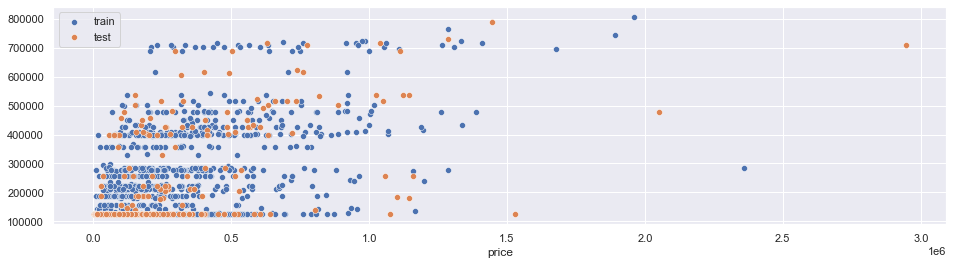

In [149]:
sns.scatterplot(y_train, y_train_pred, label='train')
sns.scatterplot(y_test, y_test_pred, label='test')

In [109]:
import matplotlib.pyplot as plt

In [110]:
# feat_importances = pd.Series(pipe.steps[1][1].feature_importances_, index=X_train.columns)
# feat_importances.sort_values(ascending=False).plot(kind='bar')

Need to figure out feature importance plot after one-hot encoding

### XGBOOST Model

In [111]:
from xgboost import XGBRegressor

#### grid search parameters

In [112]:
#https://medium.com/@juniormiranda_23768/ensemble-methods-tuning-a-xgboost-model-with-scikit-learn-54ff669f988a
parameters = {'xgbr__learning_rate': [0.001, 0.01, 0.1],
              'xgbr__n_estimators':[100,  200, 300, 500],
              'xgbr__max_depth': [1,2,4,6],
              'xgbr__gamma':[0.01, 0.1,.2]
             }

#### make scores and pipeline

In [113]:
scorer=make_scorer(mean_squared_error, greater_is_better=False)

In [114]:
steps=[('prep', preprocessor),
       ('xgbr', XGBRegressor(gamma=0.01,
                         learning_rate= 0.01,
                         max_depth= 1,
                         n_estimators= 500,
                         random_state=0))
      ]
pipe=Pipeline(steps)
# pipe = pipe.fit(X_train, y_train)



#### grid search and cross validation

In [115]:
model_gsv=GridSearchCV(pipe, parameters, cv=5, scoring=scorer, return_train_score=True)

In [116]:
import warnings
warnings.filterwarnings("ignore")
import time
t0 = time.time()

#### grid search and cross validation

In [117]:

%%time


model_gsv = model_gsv.fit(X_train, y_train)

CPU times: user 1h 56min 6s, sys: 4min 21s, total: 2h 27s
Wall time: 25min 2s


#### save and reload the model

In [2]:
# import joblib

# #save model or results
# joblib.dump(model_gsv, 'model_file_name.pkl')

# #load model for further usage
# joblib.load("model_file_name.pkl")

In [5]:
# result=model_gsv.cv_results_
# result
# pd.DataFrame(result).head() #[['param_xgbr__learning_rate', 'param_xgbr__n_estimators','param_xgbr__max_depth','param_xgbr__gamma','mean_test_score','rank_test_score']].head()

In [119]:
model_gsv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_xgbr__gamma', 'param_xgbr__learning_rate', 'param_xgbr__max_depth', 'param_xgbr__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [132]:
model_gsv.best_params_

{'xgbr__gamma': 0.01,
 'xgbr__learning_rate': 0.1,
 'xgbr__max_depth': 4,
 'xgbr__n_estimators': 200}

In [121]:
pipe=model_gsv.best_estimator_

In [122]:
y_train_pred=pipe.predict(X_train)
y_test_pred=pipe.predict(X_test)

In [123]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 7.12e+04
train MSE: 9.31e+09
train R2: 0.781
test MAE: 1.23e+05
test MSE: 4.91e+10
test R2: 0.430


#### improved prediction results for both training and testing datasets

<AxesSubplot:xlabel='price'>

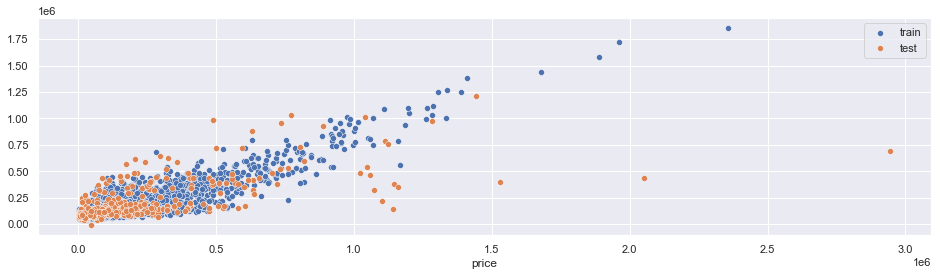

In [135]:
sns.scatterplot(y_train, y_train_pred, label='train')
sns.scatterplot(y_test, y_test_pred, label='test')

In [124]:
# feat_importances = pd.Series(pipe.steps[1][1].feature_importances_, index=X_train.columns)
# feat_importances.sort_values(ascending=False).plot(kind='bar')

In [129]:
#steal from Leizheng Wang, nice function
#this function doesn't support None as a parameter input
import matplotlib.pyplot as plt
import numpy as np
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']
    params = grid.param_grid
    
    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))              ##
    
    params=grid.param_grid   
    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    
    pram_preformace_in_best = {}                         #{}

    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])           ##
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
#         best_index   [ 1  4  7 10 13 16 19 22]
        print(best_index)
        
        #print(params[p])
        
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()


#### Tunning Parameters Sensitivity display

[ 41  89 137]
[ 9 25 41]
[33 37 41 45]
[40 41 42 43]


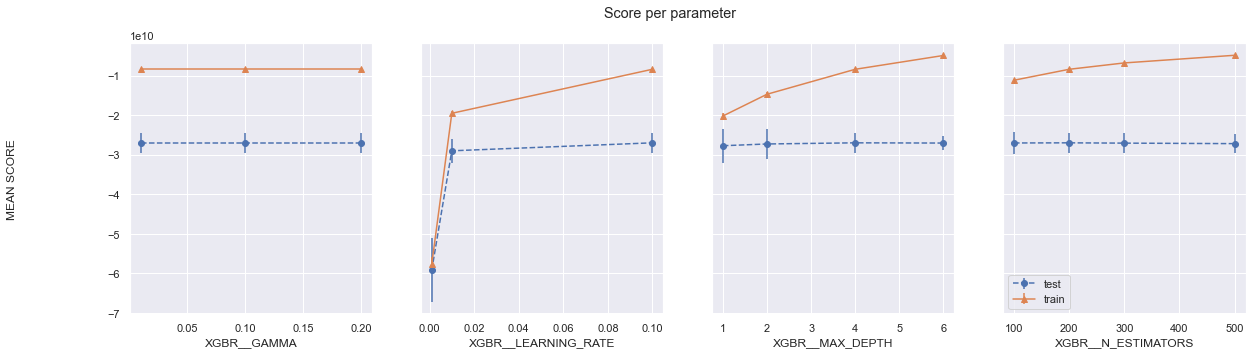

In [130]:
plot_search_results(model_gsv)

# Summary and Recommendation

***Why:***
    
    - Predict the price make-up product and provide insights explain recommended price to customers
***Method:***

    - End to End regression exercises
***Learning and Challenges***

    - Realistic workflow for data cleaning, EDA, Feature engineering
    - Price and cost are two leading indicators for price prediction
    - Strong collinearity among cost and weight, depth and height (Potential overfitting)
    - Significant improvement of performance from Random Forest Model to XGBOOST model
    - Many interesting patterns in time series data such as most transaction happens on Friday; there are two high price seasons etc. We could use these trends to improve model prediction later
***Lessons Learned and Best Practices:*** 

    - Focus on feature engineering, and data QC
    - ML Pipeline avoid data leakage, makes modeling easy to read and maintain 
    - XGBOOST outperforms Random Forest in the preliminary test
***Plan Forward:***

    - Improve feature engineering; 
